In [83]:
# 导入需要的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# 忽略警告
warnings.filterwarnings('ignore')
# 读取csv文件，并查看前五行
df = pd.read_csv("data/Area1_Load_hour.csv")
# 获取2012年-2015年1-10的数据
df = df[(df['Time'] >= '2012-01-01') & (df['Time'] <= '2015-01-11')]

print(df.head())

                      Time         Load
26280  2012-01-01 00:00:00  3967.259968
26281  2012-01-01 01:00:00  3563.567968
26282  2012-01-01 02:00:00  3283.864576
26283  2012-01-01 03:00:00  3101.586496
26284  2012-01-01 04:00:00  2972.481952


In [84]:
# 获取天气数据
weather = pd.read_csv("data/Area1_Weather_clean.csv")
# 获取2012年-2015年1-10的数据
weather = weather[(weather['YMD'] >= '2012-01-01') & (weather['YMD'] < '2015-01-11')]
# 合并数据
# df时间格式与weather时间格式不一样，需要转换
df['Time'] = pd.to_datetime(df['Time']).dt.strftime('%Y-%m-%d')
weather['YMD'] = pd.to_datetime(weather['YMD']).dt.strftime('%Y-%m-%d')
# 合并数据
data = pd.merge(df, weather, left_on='Time', right_on='YMD', how='left')


# 将前24小时的数据作为特征
for i in range(1, 25):
    data['load_t' + str(i)] = data['Load'].shift(i)
# 删除前24小时的数据
data = data.dropna()
# 删除不需要的列
data = data.drop(['YMD'], axis=1)
# 保存数据
# data.to_csv("data/Area1_Weather_Load_Hour.csv", index=False)


In [85]:
# 'std', 'norm_minmax', 'norm_mean'
flag_fs = 'std'
data = pd.read_csv("data/Area1_Weather_Load_Hour.csv")
data = data.drop(['Time'], axis=1)
data = np.array(data)

# 对数据进行归一化处理
if flag_fs == 'std': # 标准化
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0, ddof=1)
    data = (data - mean) / std
elif flag_fs == 'norm_minmax': # 最小最大归一化
    xmin = np.amin(data, axis=0)
    xmax = np.amax(data, axis=0)
    data = (data - xmin) / (xmax - xmin)
elif flag_fs == 'norm_mean': # 均值归一化
    xmin = np.amin(data, axis=0)
    xmax = np.amax(data, axis=0)
    mean = np.mean(data, axis=0)
    data = (data - mean) / (xmax - xmin)

In [86]:
print(data.shape)

(26472, 30)


In [87]:
m_all = len(data) # 数据集总行数
m_test = 271*24 # 测试集数量
m_train = m_all - m_test # 训练集数量
d = len(data[0])-1 # X的维数

X = data[:,1:] # 特征数据
Y = data[:,1]  # 标签数据


# 验证输入输出的维数是否正确
print(X.shape)
print(Y.shape)

(26472, 29)
(26472,)


In [88]:
# 将数据集划分为测试集和验证集  
X_train = X[:m_train].T
X_test = X[m_train:].T
y_train = Y[:m_train]
y_test = Y[m_train:]
# 查看测试集和验证集的大小
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (29, 19968)
X_test shape: (29, 6504)
y_train shape: (19968,)
y_test shape: (6504,)


(19968, 1, 29) (19968,) (6504, 1, 29) (6504,)
Epoch 1/250
312/312 - 2s - loss: 0.3341 - val_loss: 0.0990 - 2s/epoch - 6ms/step
Epoch 2/250
312/312 - 0s - loss: 0.0398 - val_loss: 0.0911 - 448ms/epoch - 1ms/step
Epoch 3/250
312/312 - 0s - loss: 0.0203 - val_loss: 0.1415 - 446ms/epoch - 1ms/step
Epoch 4/250
312/312 - 0s - loss: 0.0148 - val_loss: 0.1379 - 448ms/epoch - 1ms/step
Epoch 5/250
312/312 - 0s - loss: 0.0099 - val_loss: 0.0892 - 414ms/epoch - 1ms/step
Epoch 6/250
312/312 - 0s - loss: 0.0059 - val_loss: 0.0401 - 493ms/epoch - 2ms/step
Epoch 7/250
312/312 - 0s - loss: 0.0035 - val_loss: 0.0131 - 445ms/epoch - 1ms/step
Epoch 8/250
312/312 - 0s - loss: 0.0025 - val_loss: 0.0041 - 442ms/epoch - 1ms/step
Epoch 9/250
312/312 - 0s - loss: 0.0024 - val_loss: 0.0020 - 437ms/epoch - 1ms/step
Epoch 10/250
312/312 - 0s - loss: 0.0028 - val_loss: 0.0026 - 453ms/epoch - 1ms/step
Epoch 11/250
312/312 - 0s - loss: 0.0032 - val_loss: 0.0031 - 419ms/epoch - 1ms/step
Epoch 12/250
312/312 - 0s - los

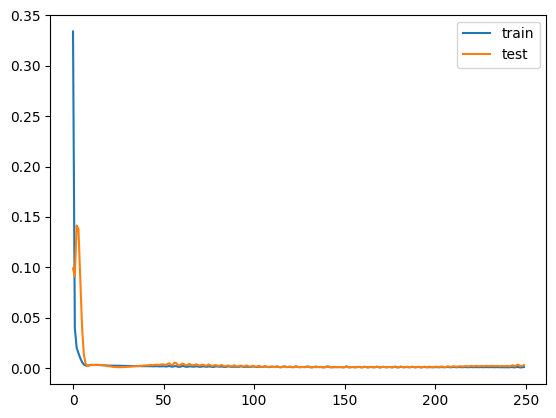

204/204 [==============================] - 0s 806us/step
Test RMSE: 0.055
Test mape: 0.126


In [89]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
# from sklearn.metrics import mea

# calculate MAPE
def mean_absolute_percentage_error(real, predict):
    res = 0
    count = 0
    for i in range(len(real)):
        if real[i] != 0:
            res += abs((predict[i]-real[i])/real[i])
            count += 1
    return res/count

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]

    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


train_X = X_train.T
test_X = X_test.T
train_y = y_train = Y[:m_train]
test_y = y_test

# 将训练集和测试集的输入特征变形为三维
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# 设计网络
model = Sequential()  # 创建一个空的网络模型
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))  # 添加LSTM层，输出维度为64
model.add(Dense(1))  # 添加全连接层，输出维度为1
model.compile(loss='mse', optimizer='adam')  # 编译模型，损失函数为MSE，优化器为adam
# 拟合网络模型
history = model.fit(train_X, train_y, epochs=250, batch_size=64, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)  # 训练参数设置：迭代次数为250次，批量大小为32，验证集为测试集，打印信息模式为2，打乱数据为True
# 画出损失函数曲线
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# 做出预测
yhat = model.predict(test_X)  # 输入测试集，进行预测
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))  # 将测试集变形为二维

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# calculate MAPE
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
print('Test mape: %.3f' % mape)

  1/624 [..............................] - ETA: 7s

624/624 [==============================] - 0s 757us/step
Trainset RMSE = 0.051


Text(0.5, 1.0, 'Train Data')

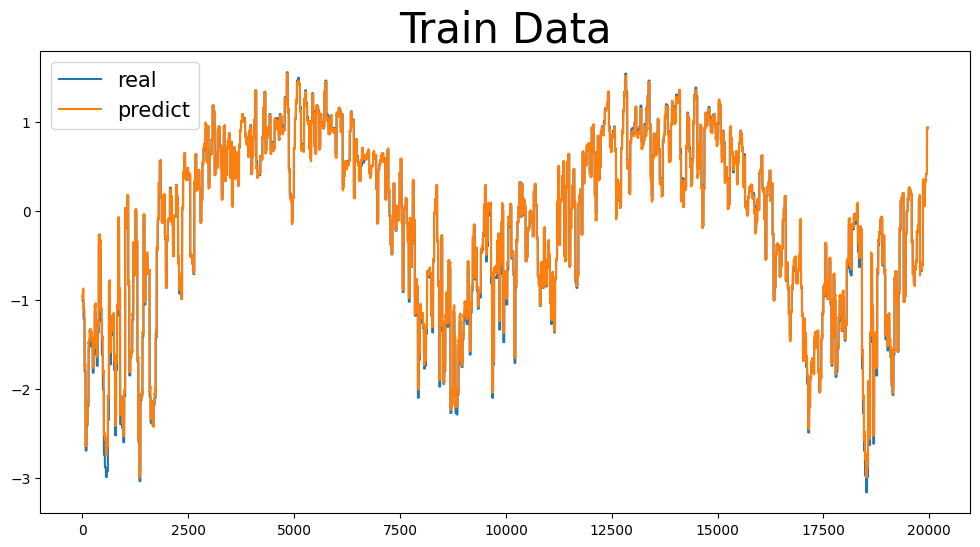

In [90]:
#在训练集上的拟合结果
y_train_predict=model.predict(train_X)
y_train_predict=y_train_predict[:,0]
e = y_train_predict - y_train  # 误差，预测值减去真实值
mse = np.dot(e, e.T) / m_train  # 计算均方误差
rmse = np.sqrt(mse)  # 计算均方根误差
print(f'Trainset RMSE = {rmse.item(0):.3f}')  # 打印均方根误差，保留三位小数

# 画出预测值和真实值的对比图
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict.reshape(-1,1))],axis=1)  # 将y_train和y_train_predict按列合并
draw.iloc[:,0].plot(figsize=(12,6))  # 画出真实值的曲线
draw.iloc[:,1].plot(figsize=(12,6))  # 画出预测值的曲线
plt.legend(('real', 'predict'),fontsize='15')  # 添加图例
plt.title("Train Data",fontsize='30') #添加标题

Testset RMSE = 1.008


Text(0.5, 1.0, 'Test Data')

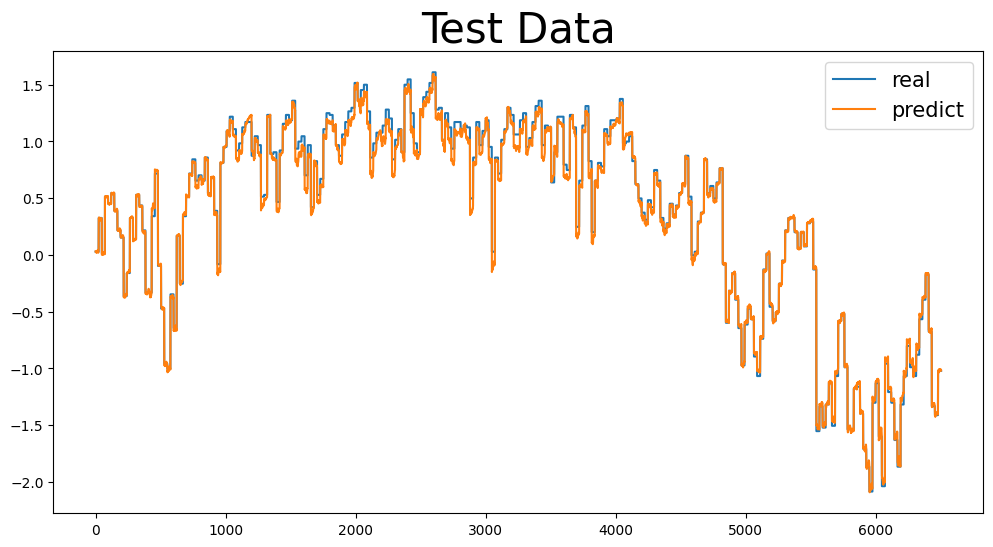

In [91]:
#在测试集上的预测
y_test_predict=yhat
y_test_predict=y_test_predict[:,0]
# 计算测试集上的RMSE
e_test = y_test_predict - y_test  # 误差，预测值减去真实值
mse_test = np.dot(e_test, e_test.T) / 19  # 计算均方误差
rmse_test = np.sqrt(mse_test)  # 计算均方根误差
print(f'Testset RMSE = {rmse_test.item(0):.3f}')  # 打印均方根误差，保留三位小数

# 画出预测值和真实值的对比图
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict.reshape(-1,1))],axis=1)  # 将y_test和y_test_predict按列合并
draw.iloc[:,0].plot(figsize=(12,6))  # 画出真实值的曲线
draw.iloc[:,1].plot(figsize=(12,6))  # 画出预测值的曲线
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')  # 添加图例
plt.title("Test Data",fontsize='30')  # 添加标题# 训练集上的结果对比